In [51]:
import time
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import contractions
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from num2words import num2words
# from spellchecker import SpellChecker
from neuspell import BertChecker

In [52]:
tweets = pd.read_csv('final.csv').iloc[:,1:]
tweet = tweets['Tweets']

In [53]:
tweet[17]

'The farmers have also demanded the creation of an Minimum Support Price (MSP) bill, to ensure that corporates cannot control the prices. \n#Vaccine_और_MSP_दो\n The World is Watching https://t.co/Fcjt3c1uG0'

In [4]:
stop_words = stopwords.words('english')
stop_words.remove('not')
punct_words = list(string.punctuation)
stop = stop_words + punct_words
stop = list(set(stop))

In [5]:
def get_easy_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [7]:
lemmatizer = WordNetLemmatizer()
spell = SpellChecker()
digitise= lambda x : re.sub('-|\s+','',num2words(x.group()))
checker = BertChecker()
checker.from_pretrained()

loading vocab from path:C:\Users\ahbaz\miniconda3\envs\tensorflow_2\lib\site-packages\neuspell\../data/checkpoints/subwordbert-probwordnoise\vocab.pkl
initializing model


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


SubwordBert(
  (bert_dropout): Dropout(p=0.2, inplace=False)
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): 

In [8]:
def f1(text):
    unurl = re.sub('http[s]?://\S+', '', str(text).strip().lower())
    
    for i in unurl.split():
        if i[0]  in ['#','@']:
            unurl = unurl.replace(i, ' ')
    unhasg_unattherate = unurl
    
    unspaced = " ".join(unhasg_unattherate.split()).strip()
    
    expanded = contractions.fix(unspaced)
    
    digit_to_word = re.sub(r'\d+', digitise, expanded)
    
    clean_words = []
    for word in word_tokenize(digit_to_word):
        if word not in stop:
            pos = pos_tag([word])
            clean_word = lemmatizer.lemmatize(word, get_easy_pos(pos[0][1]))
            clean_words.append(clean_word)
    clean_words = ' '.join(clean_words)
    
    correct_word = checker.correct(clean_words)
    
    return correct_word

In [12]:
tweet0 = tweet[:10]

st = time.time()
new_tweet0 = tweet0.apply(f1)
print("time_taken : ", time.time() - st)

time_taken :  1.4810378551483154


In [13]:
len(tweet0), len(new_tweet0)

(10, 10)

In [14]:
st = time.time()
new_tweet = tweet.apply(f1)
print("time_taken : ", time.time() - st)

time_taken :  3032.3690202236176


In [18]:
print("time for preprocessing in min: ", 3032 / 60)

time for preprocessing in min:  50.53333333333333


In [23]:
tweets['Tweets'] = new_tweet

In [24]:
tweets.head()

,Tweets,User,User_statuses_count,user_followers,User_location,User_verified,fav_count,rt_count,tweet_date
0,farmers also demand creation minimum support p...,Jimmy Kahlon,17649,334,NaN,False,0,0,2021-05-02 03:14:22
1,most right former agree sector ability feed a ...,ςααɕհ,18490,124,NaN,False,0,0,2021-05-02 03:06:46
2,farmers also demand creation minimum support p...,Harbir Virk,18901,189,NaN,False,0,0,2021-05-02 03:04:12
3,farmer also demand creation minimum support pr...,MG,4312,102,Planet Earth,False,0,0,2021-05-02 03:03:06
4,caused anything related present crisis oxygen ...,sanjay singh,11216,1327,NaN,False,0,0,2021-05-02 02:56:35


In [43]:
# tweets.to_csv('output after preprocessing of tweets.csv')

In [45]:
tweets.iloc[78,0]

'saw clearly say not reasonable price investment big production life save vaccine short time need huge huge investment compared could vaccine world cheapest'

# Algorithm

In [26]:
# numpy
def phase_1(lines):
    n = len(lines)
    lines_thresh_bool = np.ones((n * n, ), dtype = np.bool)
#     lines_thresh_bool = [True] * (n * n)
    for i in range(n):
        for j in range(i + 1, n):
            
            line1 = lines[i]
            n1 = len(line1)
            line2 = lines[j]
            n2 = len(line2)
            
            n_max = max(n1, n2)
            n_min = min(n1, n2)

            count_true = 0
            
            for k in range(n_min):
                if line1[k] == line2[k]:
                    count_true += 1
            
            thresh_true = round(count_true / n_max, 2)
            thresh_false = 1 - thresh_true

            if (thresh_true <= 0.25) or (0.75 <= thresh_false):
                lines_thresh_bool[(n * i) + j] = False
                lines_thresh_bool[i + (n * j)] = False

    return lines_thresh_bool.reshape(n, n)

In [34]:
def phase_2(lines, lines_thresh_bool):
    tweet_lines_thresh_bool = pd.DataFrame(lines_thresh_bool.T)
    tweet_lines_thresh_bool.insert(0, 'tweet', pd.DataFrame(np.array(lines)))

    l = set()
    for i in range(len(lines)):
        d = tweet_lines_thresh_bool[tweet_lines_thresh_bool[i] == True]['tweet'].to_dict()
        for k in d:
            d[k] = len(d[k])
        d = dict(sorted(d.items(), key = lambda x: x[1], reverse=True))
        l.add(list(d.keys())[0])
    l = list(l)

    refined_tweets = tweet_lines_thresh_bool.loc[l, 'tweet'].to_list()
    return refined_tweets, l

In [30]:
a_tweets = []
for t in new_tweet:
    a_tweets.append(word_tokenize(str(t).strip()))
len(a_tweets)

15174

In [32]:
st1 = time.time()

lines_thresh_bool = phase_1(a_tweets)

ed1 = time.time()

st2 = time.time()

refined_tweets, l= phase_2(a_tweets, lines_thresh_bool)

ed2 = time.time()

print('time of phase_1:', ed1 - st1)
print('time of phase_2:', ed2 - st2)
print('time of phase_1 + phase_2:', (ed1 - st1) + (ed2 - st2))

C:\Users\ahbaz\miniconda3\envs\tensorflow_2\lib\site-packages\ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


time of phase_1: 351.7458848953247
time of phase_2: 22.71674919128418
time of phase_1 + phase_2: 374.4626340866089


In [35]:
len(tweet), len(refined_tweets)

(15174, 11129)

<AxesSubplot:>

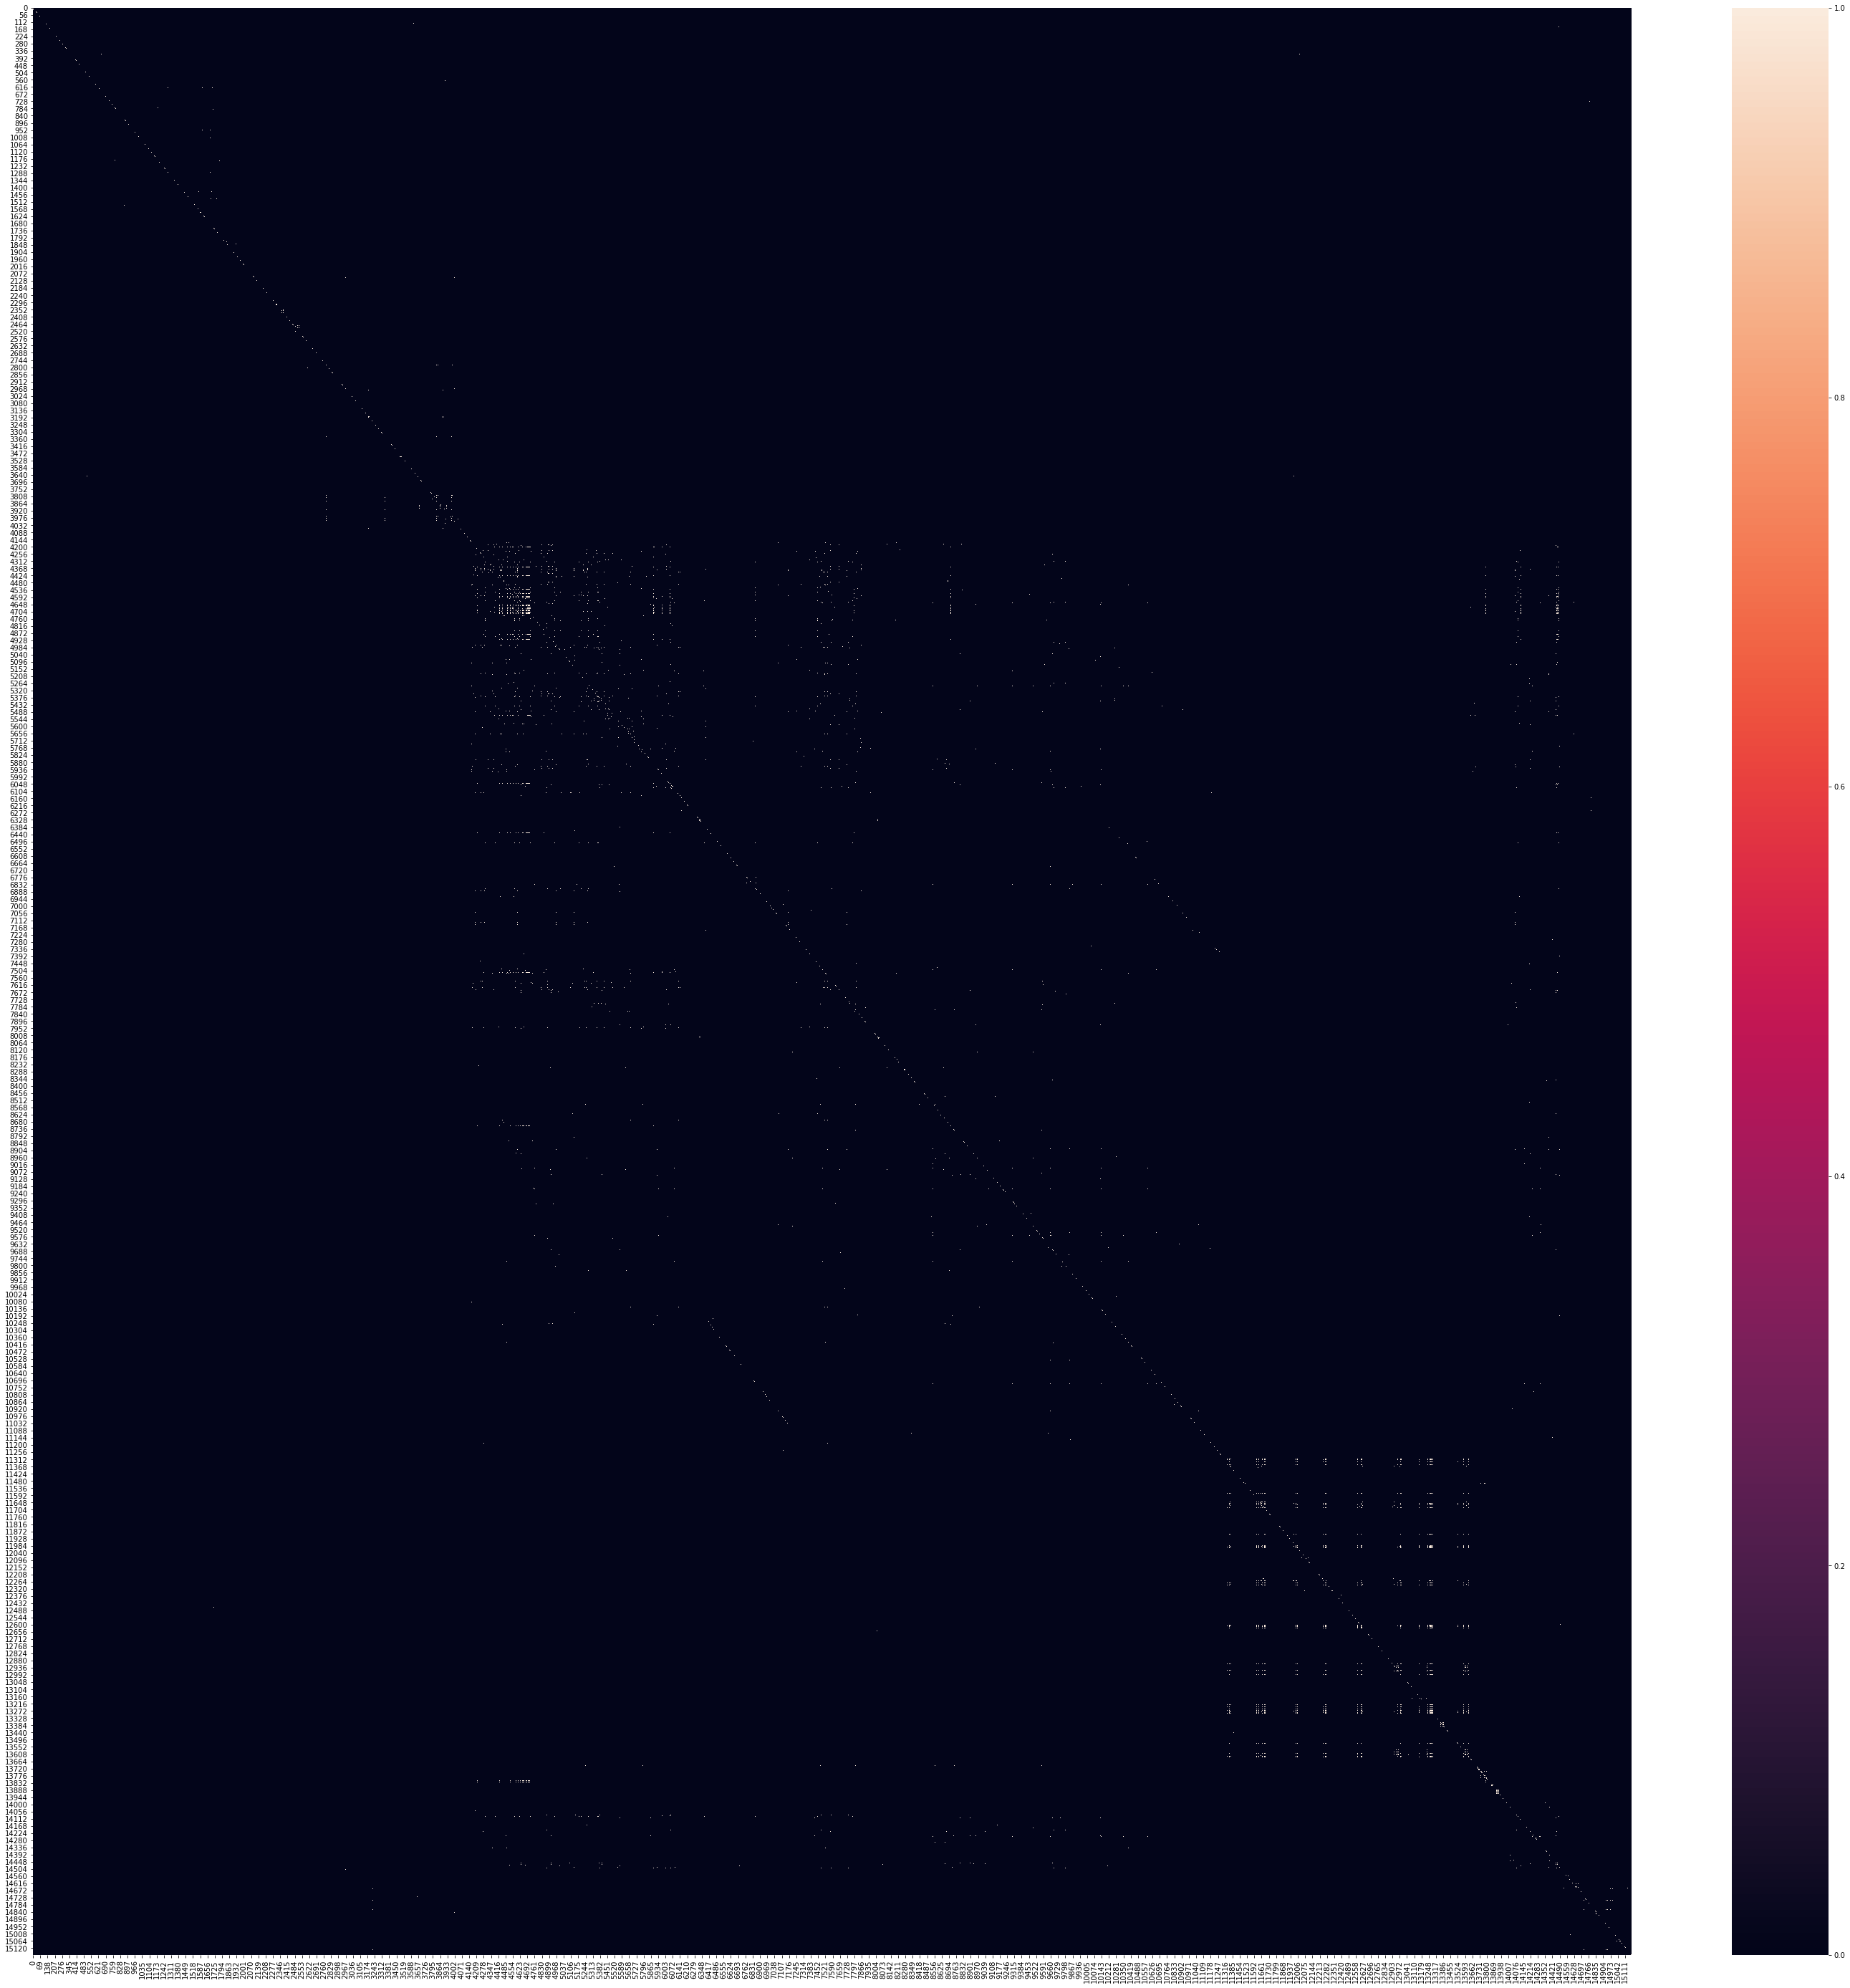

In [36]:
plt.figure(figsize = (50,50))
sns.heatmap(lines_thresh_bool)

In [39]:
refined_tweets, l= phase_2(a_tweets, lines_thresh_bool)

C:\Users\ahbaz\miniconda3\envs\tensorflow_2\lib\site-packages\ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


In [41]:
tweets.iloc[l,].to_csv("")

,Tweets,User,User_statuses_count,user_followers,User_location,User_verified,fav_count,rt_count,tweet_date
1,most right former agree sector ability feed a ...,ςααɕհ,18490,124,NaN,False,0,0,2021-05-02 03:06:46
4,caused anything related present crisis oxygen ...,sanjay singh,11216,1327,NaN,False,0,0,2021-05-02 02:56:35
7,I ask gaaru whether join go fail enforce rule ...,Yaseen Mohammad,2421,37,"Hyderabad,India",False,1,0,2021-05-02 02:47:43
9,argue someone taking vaccine afraid side effec...,Cindy M,14270,224,"California, USA",False,2,0,2021-05-02 02:40:09
10,ability minimum support price must act minimum...,Jassu 🇨🇦 🌾ਗਰਮ ਖਿਆਲੀ,89571,4280,Canada 🍁,False,15,24,2021-05-02 02:38:51
...,...,...,...,...,...,...,...,...,...
15169,tell deny vaccine rate ₹sixhundred I merely as...,Paras Abhigyan,1459,44,Akhand Bharat,False,0,0,2021-04-24 07:43:46
15170,people spending onethousand ' s rupee vaccine ...,My U,7552,105,NaN,False,0,0,2021-04-24 07:42:12
15171,anyways not forget vaccine available you in ca...,acabthema,3199,127,your favorite,False,12,1,2021-04-24 07:21:12
15172,technique different procure raw material vacci...,Chandramouli,1231,36,Sweden,False,0,0,2021-04-24 07:18:00


In [48]:
# tweets.loc[l].to_csv('output after algorithm of tweets.csv', index = False)

In [50]:
print("total time (Preprocssing + Algorithm)",  3032 + 374, 'in sec')
print("total time (Preprocssing + Algorithm)",  (3032 + 374) / 60, 'in min')

total time (Preprocssing + Algorithm) 3406 in sec
total time (Preprocssing + Algorithm) 56.766666666666666 in min
